In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking
from mlxtend.classifier import StackingClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

## Loading Data

In [2]:
train_df = pd.read_csv('survey.csv')
print(train_df.shape[0]," rows and ",train_df.shape[1]," columns ")
print(train_df.describe())
print(train_df.info())

1259  rows and  27  columns 
                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
Timestamp                    1259 non-null object
Age                          1259 non-null int64
Gender                       1259 non-null object
Country                      1259 non-null object
state                        744 non-null object
self_employed                1241 non-null object
family_history               1259 non-null object
treatment                    1259 non-null object
work_interfere               995 non-null object
no_employees                 1259 non-null object
remote_work                  1259 non-null object
tech_company                 1259 non-null object
benefits                     1259 non-null object
care_options                 1259 non

## Data Cleaning

In [3]:
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

print(train_df.isnull().sum().max())
train_df.head(5)

264


,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


## Changing NaN values

In [4]:
defaultInt = 0
defaultString = 'NaN'

intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']

In [5]:
# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)  

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [6]:
gender = train_df['Gender'].str.lower()
gender = train_df['Gender'].unique()

#based on unique values in the gender column 
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)
        
#unwanted values
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())



['female' 'male' 'trans']


In [7]:
#missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

#median values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)


In [8]:
#change NaN to NOT self_employed
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [9]:
#change NaN to "Don't know"
train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


## Encoding Data

In [10]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


### Testing there aren't any missing data

In [11]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

#Features Scaling We're going to

                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

### Covariance Matrix. Variability comparison between categories of variables

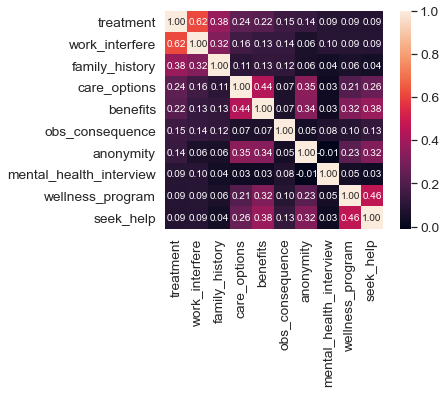

In [12]:
k = 10 #number of variables for heatmap
corrmat = train_df.corr()
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Charts to see data relationship

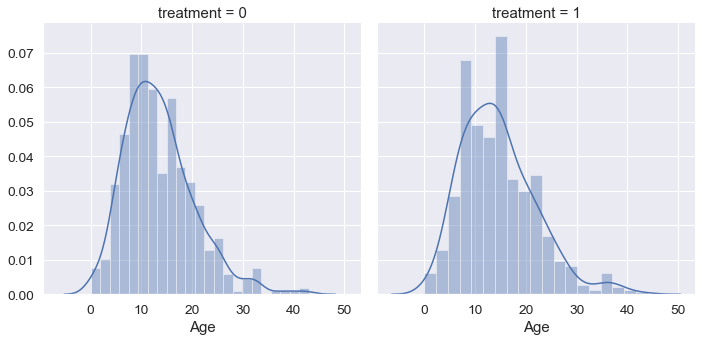

In [13]:
#age distribution
g = sns.FacetGrid(train_df, col='treatment', height=5)
g = g.map(sns.distplot, "Age")

Text(0.5, 1.0, 'Total Distribuition by treated or not')

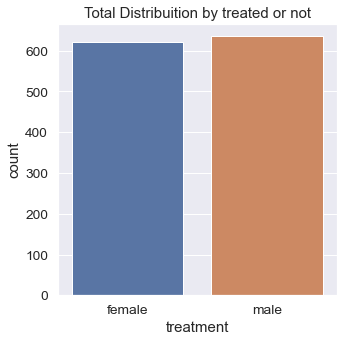

In [14]:
#distribution based on treatment
plt.figure(figsize=(5,5))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

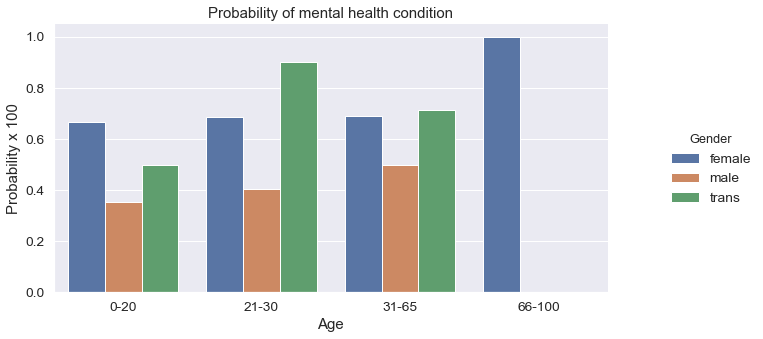

In [15]:
#nested barplot for class and sex
o = labelDict['label_age_range']

g = sns.catplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()


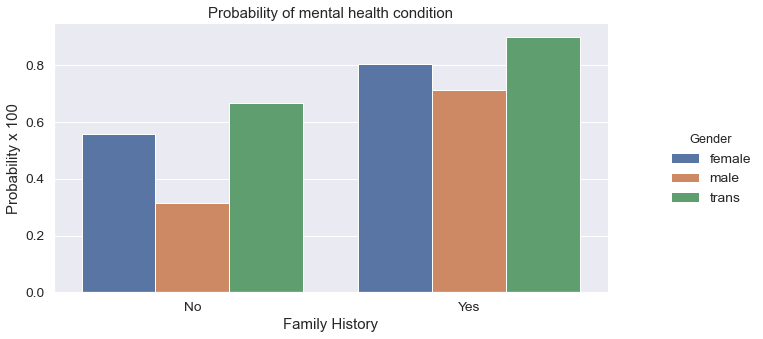

In [16]:
#Barplot to show probabilities for family history

o = labelDict['label_family_history']
g = sns.catplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

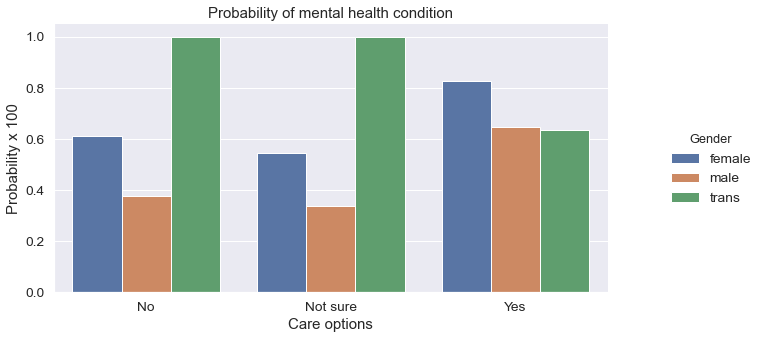

In [17]:
# Barplot to show probabilities for care options

o = labelDict['label_care_options']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

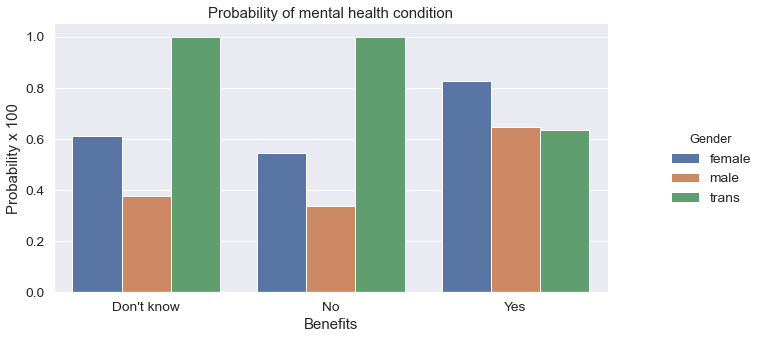

In [18]:
# Barplot to show probabilities for benefits

o = labelDict['label_benefits']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

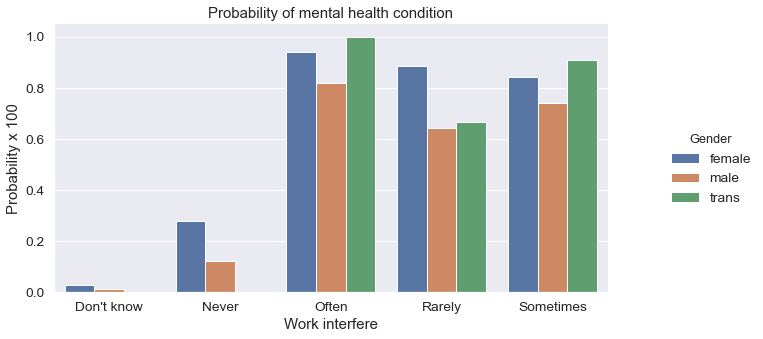

In [19]:
# Barplot to show probabilities for work interfere
o = labelDict['label_work_interfere']
g = sns.catplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

## Scaling And Fitting
#### age is scaled

In [20]:
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


### Splitting the dataset

In [21]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

In [22]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.cv_results_

    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

### Defining Evaluation Metrics 

In [23]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    # accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    # null accuracy
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Confusion matrix
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Metricsfrom  confusion matrix
    # classification accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    # classification error
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    # false positive rate
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    # precision
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    # AUC
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=8)
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    # return 1 if above 0.3 and 0 otherwise
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])   
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # specificity and sensitivity
    def evaluate_threshold(threshold):
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    #setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    return accuracy

### Logistic Regression

########### Logistic Regression ###############
Accuracy: 0.7962962962962963
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


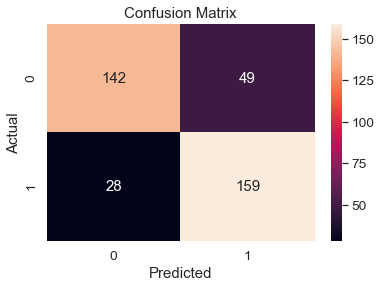

Classification Accuracy: 0.7962962962962963
Classification Error: 0.20370370370370372
False Positive Rate: 0.25654450261780104
Precision: 0.7644230769230769
AUC Score: 0.7968614385306716
Cross-validated AUC: 0.8752694172427035
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.09193053 0.90806947]
 [0.95991564 0.04008436]
 [0.96547467 0.03452533]
 [0.78757121 0.21242879]
 [0.38959922 0.61040078]
 [0.05264207 0.94735793]
 [0.75035574 0.24964426]
 [0.19065116 0.80934884]
 [0.61612081 0.38387919]
 [0.47699963 0.52300037]]
First 10 predicted probabilities:
 [[0.90806947]
 [0.04008436]
 [0.03452533]
 [0.21242879]
 [0.61040078]
 [0.94735793]
 [0.24964426]
 [0.80934884]
 [0.38387919]
 [0.52300037]]


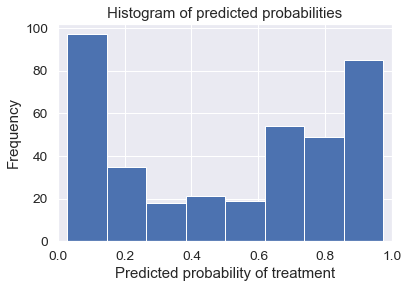

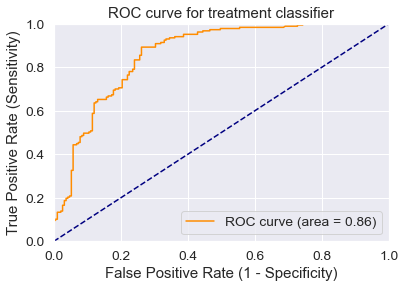

[[142  49]
 [ 28 159]]


In [24]:
#training
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

#predicting
y_pred_class = logreg.predict(X_test)

print('########### Logistic Regression ###############')

accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)

#Data for final graph
methodDict['Log. Regres.'] = accuracy_score * 100

### KNN Classifier

Rand. Best Score:  0.8194112967382657
Rand. Best Params:  {'weights': 'uniform', 'n_neighbors': 15}
[0.82, 0.818, 0.82, 0.819, 0.819, 0.811, 0.819, 0.82, 0.815, 0.819, 0.818, 0.819, 0.819, 0.814, 0.815, 0.819, 0.815, 0.815, 0.819, 0.814]
########### KNeighborsClassifier ###############
Accuracy: 0.8042328042328042
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


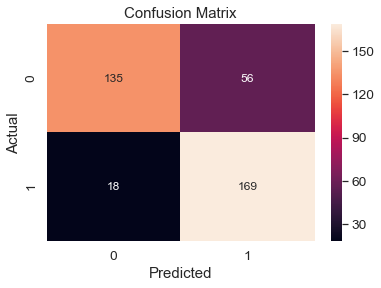

Classification Accuracy: 0.8042328042328042
Classification Error: 0.1957671957671958
False Positive Rate: 0.2931937172774869
Precision: 0.7511111111111111
AUC Score: 0.8052747991152673
Cross-validated AUC: 0.8788016433051714
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.33333333 0.66666667]
 [1.         0.        ]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.37037037 0.62962963]
 [0.03703704 0.96296296]
 [0.59259259 0.40740741]
 [0.37037037 0.62962963]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]]
First 10 predicted probabilities:
 [[0.66666667]
 [0.        ]
 [0.        ]
 [0.33333333]
 [0.62962963]
 [0.96296296]
 [0.40740741]
 [0.62962963]
 [0.66666667]
 [0.66666667]]


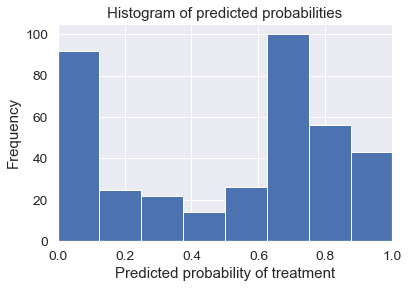

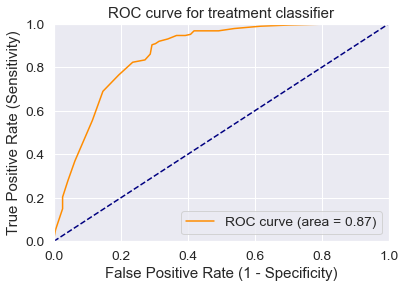

[[135  56]
 [ 18 169]]


In [25]:
knn = KNeighborsClassifier(n_neighbors=5)

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

param_dist = dict(n_neighbors=k_range, weights=weight_options)
tuningRandomizedSearchCV(knn, param_dist)

# training
knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
knn.fit(X_train, y_train)

# predicting
y_pred_class = knn.predict(X_test)

print('########### KNeighborsClassifier ###############')

accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

#Data for final graph
methodDict['KNN'] = accuracy_score * 100

### Decision Tree Classifier

C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Rand. Best Score:  0.8305489260143198
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 8}


C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Deprecation

[0.831, 0.831, 0.827, 0.831, 0.813, 0.831, 0.831, 0.829, 0.831, 0.804, 0.83, 0.831, 0.831, 0.831, 0.83, 0.83, 0.83, 0.814, 0.825, 0.827]
########### Tree classifier ###############
Accuracy: 0.8068783068783069
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


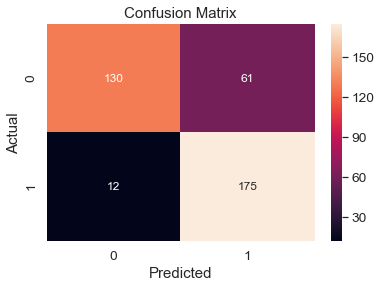

Classification Accuracy: 0.8068783068783069
Classification Error: 0.19312169312169314
False Positive Rate: 0.3193717277486911
Precision: 0.7415254237288136
AUC Score: 0.8082285746283282
Cross-validated AUC: 0.8855386744751664
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.18       0.82      ]
 [0.95575221 0.04424779]
 [0.95575221 0.04424779]
 [0.95575221 0.04424779]
 [0.37583893 0.62416107]
 [0.18       0.82      ]
 [0.82352941 0.17647059]
 [0.37583893 0.62416107]
 [0.22018349 0.77981651]
 [0.22018349 0.77981651]]
First 10 predicted probabilities:
 [[0.82      ]
 [0.04424779]
 [0.04424779]
 [0.04424779]
 [0.62416107]
 [0.82      ]
 [0.17647059]
 [0.62416107]
 [0.77981651]
 [0.77981651]]


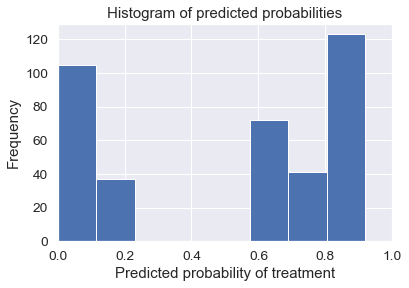

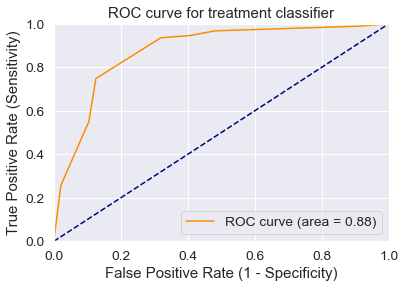

[[130  61]
 [ 12 175]]


In [26]:
tree = DecisionTreeClassifier()
featuresSize = feature_cols.__len__()
param_dist = {"max_depth": [3, None],
          "max_features": randint(1, featuresSize),
          "min_samples_split": randint(2, 9),
          "min_samples_leaf": randint(1, 9),
          "criterion": ["gini", "entropy"]}
tuningRandomizedSearchCV(tree, param_dist)

# training
tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
tree.fit(X_train, y_train)

# predicting
y_pred_class = tree.predict(X_test)

print('########### Tree classifier ###############')

accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

#Data for final graph
methodDict['Tree clas.'] = accuracy_score * 100

### Random Forest

Rand. Best Score:  0.8321400159108989
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}
[0.831, 0.831, 0.831, 0.831, 0.831, 0.833, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.835, 0.831, 0.831, 0.831]
########### Random Forests ###############
Accuracy: 0.8121693121693122
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


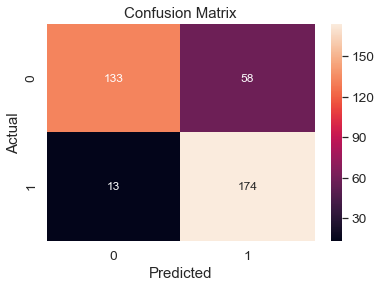

Classification Accuracy: 0.8121693121693122
Classification Error: 0.1878306878306878
False Positive Rate: 0.3036649214659686
Precision: 0.75
AUC Score: 0.8134081809782457
Cross-validated AUC: 0.893237767217102
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.2555794  0.7444206 ]
 [0.95069083 0.04930917]
 [0.93851009 0.06148991]
 [0.87096597 0.12903403]
 [0.40653554 0.59346446]
 [0.17282958 0.82717042]
 [0.89450448 0.10549552]
 [0.4065912  0.5934088 ]
 [0.20540631 0.79459369]
 [0.19337644 0.80662356]]
First 10 predicted probabilities:
 [[0.7444206 ]
 [0.04930917]
 [0.06148991]
 [0.12903403]
 [0.59346446]
 [0.82717042]
 [0.10549552]
 [0.5934088 ]
 [0.79459369]
 [0.80662356]]


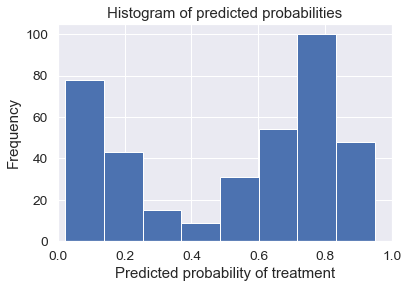

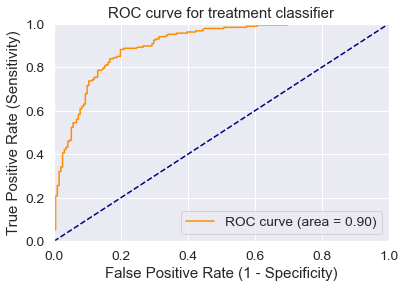

[[133  58]
 [ 13 174]]


In [27]:
forest = RandomForestClassifier(n_estimators = 20)
featuresSize = feature_cols.__len__()
param_dist = {"max_depth": [3, None],
          "max_features": randint(1, featuresSize),
          "min_samples_split": randint(2, 9),
          "min_samples_leaf": randint(1, 9),
          "criterion": ["gini", "entropy"]}
tuningRandomizedSearchCV(forest, param_dist)

# training
forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
my_forest = forest.fit(X_train, y_train)

# predicting
y_pred_class = my_forest.predict(X_test)

print('########### Random Forests ###############')

accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

#Data for final graph
methodDict['R. Forest'] = accuracy_score * 100

### Bagging

########### Bagging ###############
Accuracy: 0.7671957671957672
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


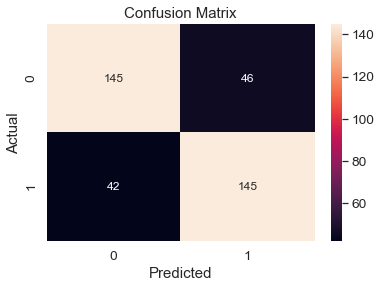

Classification Accuracy: 0.7671957671957672
Classification Error: 0.2328042328042328
False Positive Rate: 0.24083769633507854
Precision: 0.7591623036649214
AUC Score: 0.7672816865918191
Cross-validated AUC: 0.8440026161674348
First 10 predicted responses:
 [0 0 0 0 1 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.57666667 0.42333333]
 [1.         0.        ]
 [1.         0.        ]
 [0.7        0.3       ]
 [0.4        0.6       ]
 [0.3        0.7       ]
 [1.         0.        ]
 [0.7        0.3       ]
 [0.1        0.9       ]
 [0.3        0.7       ]]
First 10 predicted probabilities:
 [[0.42333333]
 [0.        ]
 [0.        ]
 [0.3       ]
 [0.6       ]
 [0.7       ]
 [0.        ]
 [0.3       ]
 [0.9       ]
 [0.7       ]]


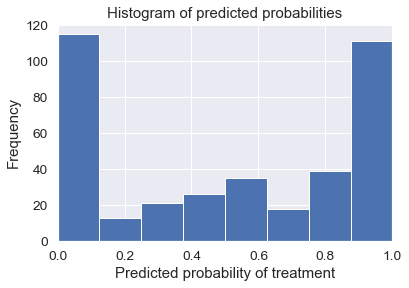

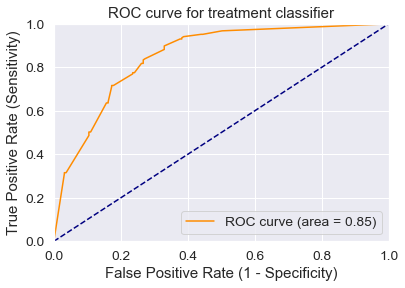

[[145  46]
 [ 42 145]]


In [28]:
# Building and fitting 
bag = BaggingClassifier(DecisionTreeClassifier(), max_samples=1.0, max_features=1.0, bootstrap_features=False)
bag.fit(X_train, y_train)

# make class predictions for the testing set
y_pred_class = bag.predict(X_test)

print('########### Bagging ###############')

accuracy_score = evalClassModel(bag, y_test, y_pred_class, True)

#Data for final graph
methodDict['Bagging'] = accuracy_score * 100

### Boosting

########### Boosting ###############
Accuracy: 0.8174603174603174
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


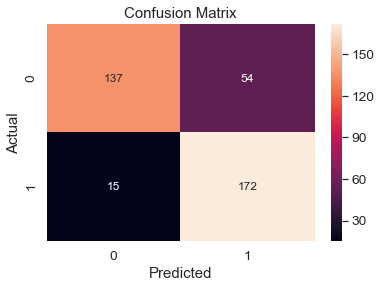

Classification Accuracy: 0.8174603174603174
Classification Error: 0.18253968253968256
False Positive Rate: 0.28272251308900526
Precision: 0.7610619469026548
AUC Score: 0.8185317915838397
Cross-validated AUC: 0.8740853414618535
First 10 predicted responses:
 [1 0 0 0 0 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.49924555 0.50075445]
 [0.50285507 0.49714493]
 [0.50291786 0.49708214]
 [0.50127788 0.49872212]
 [0.50013552 0.49986448]
 [0.49796157 0.50203843]
 [0.50046371 0.49953629]
 [0.49939483 0.50060517]
 [0.49921757 0.50078243]
 [0.49897133 0.50102867]]
First 10 predicted probabilities:
 [[0.50075445]
 [0.49714493]
 [0.49708214]
 [0.49872212]
 [0.49986448]
 [0.50203843]
 [0.49953629]
 [0.50060517]
 [0.50078243]
 [0.50102867]]


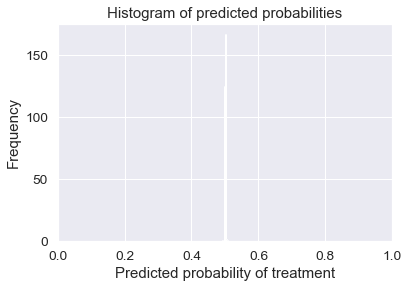

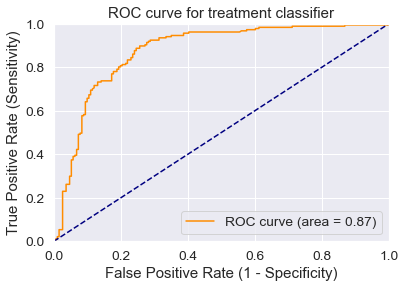

[[137  54]
 [ 15 172]]


In [29]:
# traing
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
boost = AdaBoostClassifier(base_estimator=clf, n_estimators=500)
boost.fit(X_train, y_train)

# predicting
y_pred_class = boost.predict(X_test)

print('########### Boosting ###############')

accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

#Data for final graph
methodDict['Boosting'] = accuracy_score * 100

### Stacking

########### Stacking ###############
Accuracy: 0.7592592592592593
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0]


C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


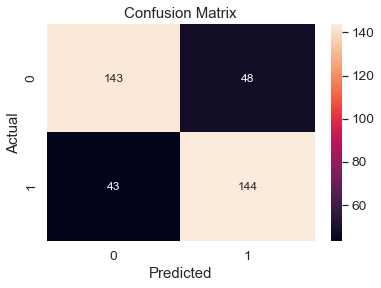

Classification Accuracy: 0.7592592592592593
Classification Error: 0.2407407407407407
False Positive Rate: 0.2513089005235602
Precision: 0.75
AUC Score: 0.7593722877061343


C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mnish\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Cross-validated AUC: 0.840591797875064
First 10 predicted responses:
 [1 0 0 0 0 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.01325837 0.98674163]
 [0.98871089 0.01128911]
 [0.98871089 0.01128911]
 [0.98871089 0.01128911]
 [0.98871089 0.01128911]
 [0.01325837 0.98674163]
 [0.98871089 0.01128911]
 [0.96926707 0.03073293]
 [0.03597054 0.96402946]
 [0.01325837 0.98674163]]
First 10 predicted probabilities:
 [[0.98674163]
 [0.01128911]
 [0.01128911]
 [0.01128911]
 [0.01128911]
 [0.98674163]
 [0.01128911]
 [0.03073293]
 [0.96402946]
 [0.98674163]]


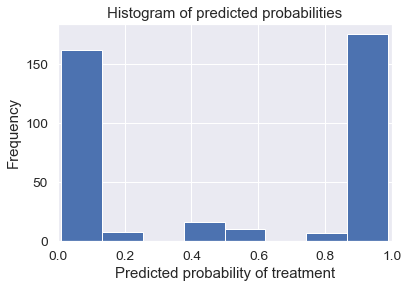

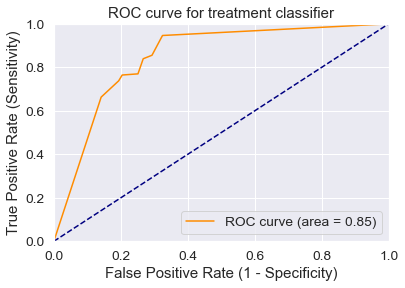

[[143  48]
 [ 43 144]]


In [30]:
# training 
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression(solver='lbfgs')
stack = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)
stack.fit(X_train, y_train)

# predicting
y_pred_class = stack.predict(X_test)

print('########### Stacking ###############')

accuracy_score = evalClassModel(stack, y_test, y_pred_class, True)

#Data for final graph
methodDict['Stacking'] = accuracy_score * 100

### Neural Network

In [31]:
import tensorflow as tf
import argparse


batch_size = 100
train_steps = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

def train_input_fn(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
        
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset


In [32]:
# feature columns
age = tf.feature_column.numeric_column("Age")
gender = tf.feature_column.numeric_column("Gender")
family_history = tf.feature_column.numeric_column("family_history")
benefits = tf.feature_column.numeric_column("benefits")
care_options = tf.feature_column.numeric_column("care_options")
anonymity = tf.feature_column.numeric_column("anonymity")
leave = tf.feature_column.numeric_column("leave")
work_interfere = tf.feature_column.numeric_column("work_interfere")
feature_columns = [age, gender, family_history, benefits, care_options, anonymity, leave, work_interfere]

In [65]:
# DNN with 2 hidden layers and 10 nodes in each hidden layer.
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,hidden_units=[10, 10],optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.1,l1_regularization_strength=0.001))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\AISHWA~1\\AppData\\Local\\Temp\\tmpivh93t7t', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000177992DCA58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [66]:
# training
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\AISHWA~1\AppData\Local\Temp\tmpivh93t7t\model.ckpt.
INFO:tensorflow:loss = 65.92312, step = 1
INFO:tensorflow:global_step/sec: 225.346
INFO:tensorflow:loss = 37.927963, step = 101 (0.445 sec)
INFO:tensorflow:global_step/sec: 416.045
INFO:tensorflow:loss = 32.25647, step = 201 (0.242 sec)
INFO:tensorflow:global_step/sec: 408.831
INFO:tensorflow:loss = 37.80479, step = 301 (0.244 sec)
INFO:tensorflow:global_step/sec: 396.351
INFO:tensorflow:loss = 29.774094, step = 401 (0.251 sec)
INFO:tensorflow:global_step/sec: 405.942
INFO:tensorflow:loss = 27.993282, step = 501 (0.247 sec)
INFO:t

In [67]:
# Evaluation
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))

print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))

#Data for final graph
accuracy = eval_result['accuracy'] * 100
methodDict['NN DNNClasif.'] = accuracy

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-05T16:07:52Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\AISHWA~1\AppData\Local\Temp\tmpivh93t7t\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-04-05-16:07:54
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8068783, accuracy_baseline = 0.505291, auc = 0.88991237, auc_precision_recall = 0.86401784, average_loss = 0.4488305, global_step = 1000, label/mean = 0.49470899, loss = 42.414482, precision = 0.7478261, prediction/mean = 0.52053064, recall = 0.9197861
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\AISHWA~1\AppData\Loc

In [68]:
# predicting
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\AISHWA~1\AppData\Local\Temp\tmpivh93t7t\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [69]:
template = ('\nIndex: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')
col1 = []
col2 = []
col3 = []


for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0] 
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id] # Probability
    
    col1.append(idx) # Index
    col2.append(v) # Prediction
    col3.append(input) # Expecter
     
results = pd.DataFrame({'index':col1, 'prediction':col2, 'expected':col3})
results.head()

,index,prediction,expected
0,929,0,0
1,901,1,1
2,579,1,1
3,367,1,1
4,615,1,1


### Comparison of models used

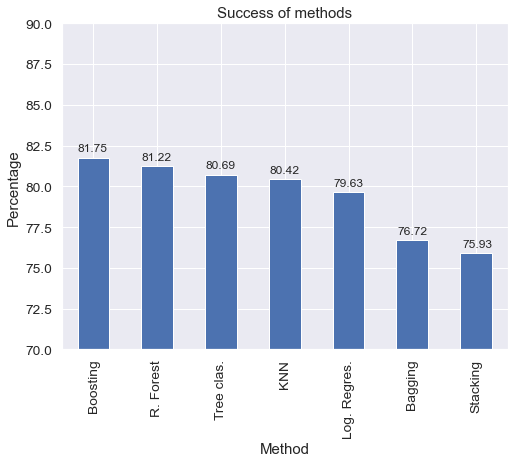

In [33]:
s = pd.Series(methodDict)
s = s.sort_values(ascending=False)
plt.figure(figsize=(8,6))

ax = s.plot(kind='bar') 
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.ylim([70.0, 90.0])
plt.xlabel('Method')
plt.ylabel('Percentage')
plt.title('Success of methods')

plt.show()

### Boosting method proves to be the best method.
### So, the predictions are made with this method using AdaBoostClassifier and saved to a csv file.

In [34]:
# Generate predictions with the best method
clf = AdaBoostClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)

# Write predictions to csv file
# We don't have any significative field so we save the index
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
# Save to file
# This file will be visible after publishing in the output section
results.to_csv(r'C:\Users\mnish\Desktop\submission.csv', index=False)
results.head()

,Index,Treatment
0,5,1
1,494,0
2,52,0
3,984,0
4,186,0
